Esketit
---

In [102]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [69]:
pre_path = 'data/'
suffix = '_w_lix_sentiment.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))

n_subs =  len(subreddits)

In [70]:
dfs = {}
for sub in subreddits:
    dfs[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

Spørgsmål:  
Hvorfor log-transformerer vi upvotes?  
Bør vi log-transformere lix?  
Hvorfor vælger vi standardisering frem for normalisering?  
Hvorfor vælger vi at evaluere på Silhuette Score i stedet for Davies Bouldin Score eller Calinski-Harabasz Score? Og for GMM hvorfor evaluerer vi ikke bare log-likelihood?  

First off, let's inspect the data transformations
---
Hypothesis: We want to log transform likes.
Then we want to either standardize or normalize all 3 parameters, so they are equally distant. Unless of course we want some parameter to have a higher weight?
For the standardize/normalize we should do the 3 scatterplots, 3 for normal and 3 for standard

### Log-transforming likes (Should be shown in report but not relevant in optimization)

In [84]:
# dt['log_upvotes'] = dt['upvotes'].apply(lambda x: np.log(x))

# fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))

# sns.histplot(ax = axs[0], data=dt, x="upvotes", log_scale = False)
# sns.histplot(ax = axs[1], data=dt, x="upvotes", log_scale = True)

# fig.suptitle(f'Upvotes vs. log-transformed upvotes in r/{sub_chosen}', fontsize=16)
# fig.tight_layout()
# plt.show()

Find the optimal model
---

In [147]:
# It goes something like this:
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

gmm_sil = {}
hierarchical_sil = {}
kmeans_sil = {}

gmm_cal = {}
hierarchical_cal = {}
kmeans_cal = {}

n_clusters_range = range(2, 20)


for sub, df in dfs.items():
    df = df[attribute_cols]

    gmm_sil[sub] = []
    hierarchical_sil[sub] = []
    kmeans_sil[sub] = []

    gmm_cal[sub] = []
    hierarchical_cal[sub] = []
    kmeans_cal[sub] = []


    points = StandardScaler().fit_transform(df)
    # points = minmax_scale(df, axis = 0)

    for n_clusters in n_clusters_range:

        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
        GMM = GaussianMixture(n_components=n_clusters, random_state = 42)

        hierarchical.fit(points)
        kmeans.fit(points)
        GMM.fit(points)


        hierarchical_sil[sub].append(silhouette_score(points, hierarchical.labels_))
        hierarchical_cal[sub].append(calinski_harabasz_score(points, hierarchical.labels_))

        kmeans_sil[sub].append(silhouette_score(points, kmeans.labels_))
        kmeans_cal[sub].append(calinski_harabasz_score(points, kmeans.labels_))

        gmm_sil[sub].append(silhouette_score(points, GMM.predict(points)))
        gmm_cal[sub].append(calinski_harabasz_score(points, GMM.predict(points)))

# How do i then choose which one is better? Should the "optimal amount of clusters" vary based on the clustering method?
# That would seem very illogical, so i guess not. Then we plot the average score for each amount of clusters


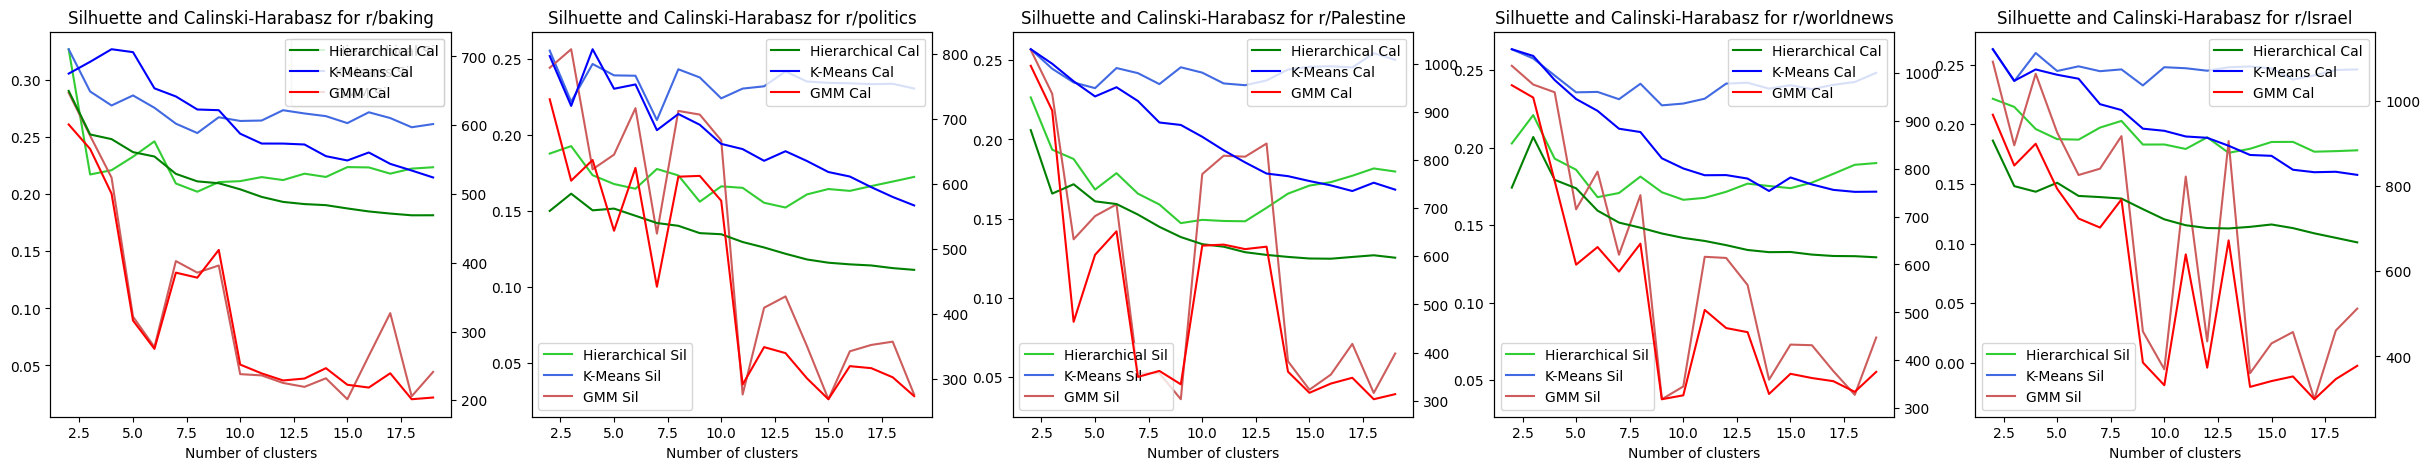

In [148]:
fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(30, 5))
x_list = n_clusters_range

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'Silhuette and Calinski-Harabasz for r/{sub}', fontsize=12)
    # axes[i].set_title(f'Silhuette score for r/{sub}', fontsize=16)
    axes[i].plot(x_list, hierarchical_sil[sub], label = 'Hierarchical Sil', color = 'limegreen')
    axes[i].plot(x_list, kmeans_sil[sub], label = 'K-Means Sil', color = 'royalblue')
    axes[i].plot(x_list, gmm_sil[sub], label = 'GMM Sil', color = 'indianred')
    cal_ax = axes[i].twinx()
    cal_ax.plot(x_list, hierarchical_cal[sub], label = 'Hierarchical Cal', color = 'green')
    cal_ax.plot(x_list, kmeans_cal[sub], label = 'K-Means Cal', color = 'blue')
    cal_ax.plot(x_list, gmm_cal[sub], label = 'GMM Cal', color = 'red')
    cal_ax.legend()
    axes[i].legend()
    axes[i].set_xlabel('Number of clusters')


plt.show()

In [ ]:
#GMM model outperforms both k-means and hierarchical clustering on both silhuette score and calinski-harabasz index.
#We primarily use the silhuette score to evaluate the clustering models, as it is a more robust metric than the calinski-harabasz index.

DBSCAN does not even come close - see for yourself on below graph
---

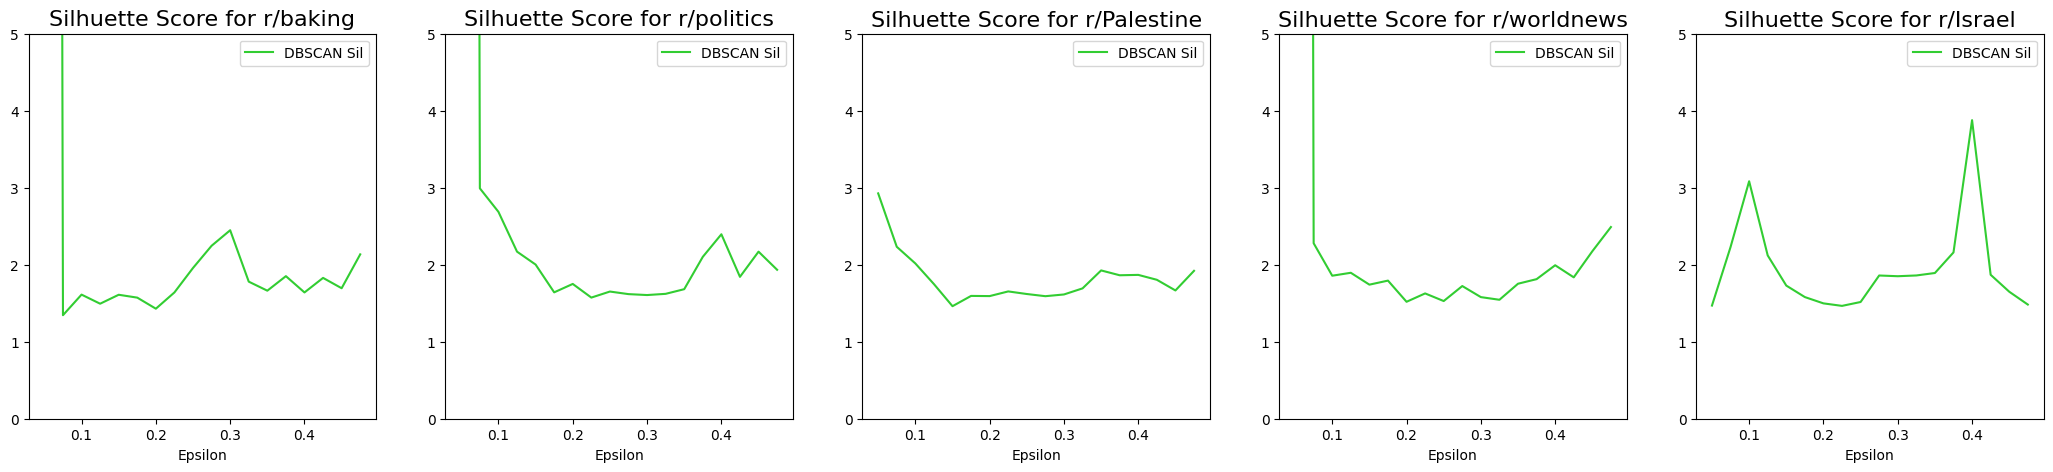

In [ ]:
# Let's do the same shit but with DBSCAN
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

DBSCAN_sil = {}

epsilons = np.arange(0.05, 0.50, 0.025)


for sub, df in dfs.items():
    df = df[attribute_cols]
    DBSCAN_sil[sub] = []
    points = StandardScaler().fit_transform(df)
    for ep in epsilons:
        dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
        dbscan.fit(points)
        
        #davies_bouldin_score not defined for single cluster
        if len(np.unique(dbscan.labels_)) == 1:
            DBSCAN_sil[sub].append(99)
        else:
            DBSCAN_sil[sub].append(davies_bouldin_score(points, dbscan.labels_))

fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(26, 5))
x_list = epsilons

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'Silhuette Score for r/{sub}', fontsize=16)
    axes[i].plot(x_list, DBSCAN_sil[sub], label = 'DBSCAN Sil', color = 'limegreen')
    axes[i].legend()
    axes[i].set_xlabel('Epsilon')
    axes[i].set_ylim(0, 5)


plt.show()

Run the optimized models here
---

In [ ]:
# #define columns for clustering
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']
optimal_clusters = {
    'Israel' : 10,
    'Palestine' : 9,
    'politics' : 11,
    'worldnews' : 9,
    'baking': 6
}

optimal_epsilons = {
    'Israel' : 0.25,
    'Palestine' : 0.15,
    'politics' : 0.30,
    'worldnews' : 0.20,
    'baking': 0.20
}

for sub, df in dfs.items():
    df_cluster = df[attribute_cols].copy()
    
    # #Standardize the data
    df_cluster_scaled = StandardScaler().fit_transform(df_cluster)

    # #Apply clustering using tuned hyperparameters
    n_clusters = optimal_clusters[sub]
    ep = optimal_epsilons[sub]

    GMM = GaussianMixture(n_components=n_clusters)
    GMM.fit(df_cluster_scaled)

    dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
    dbscan.fit(df_cluster_scaled)


    # #### Add the cluster labels to the dataframe
    # df['hierarchical_cluster'] = hierarchical.labels_
    # df['kmeans_cluster'] = kmeans.labels_
    # df['dbscan_cluster'] = dbscan.labels_

    #Assign the cluster labels
    df['DBSCAN_cluster'] = dbscan.labels_
    df['cluster_type'] = GMM.predict(df_cluster_scaled)


    # #### Export the new dataframes
    df.to_csv(f'data/{sub}_clustered.csv')


Load the data and analyze it
---

In [128]:
pre_path = 'data/'
suffix = '_clustered.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))

n_subs =  len(subreddits)

dfs_clustered = {}
for sub in subreddits:
    dfs_clustered[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

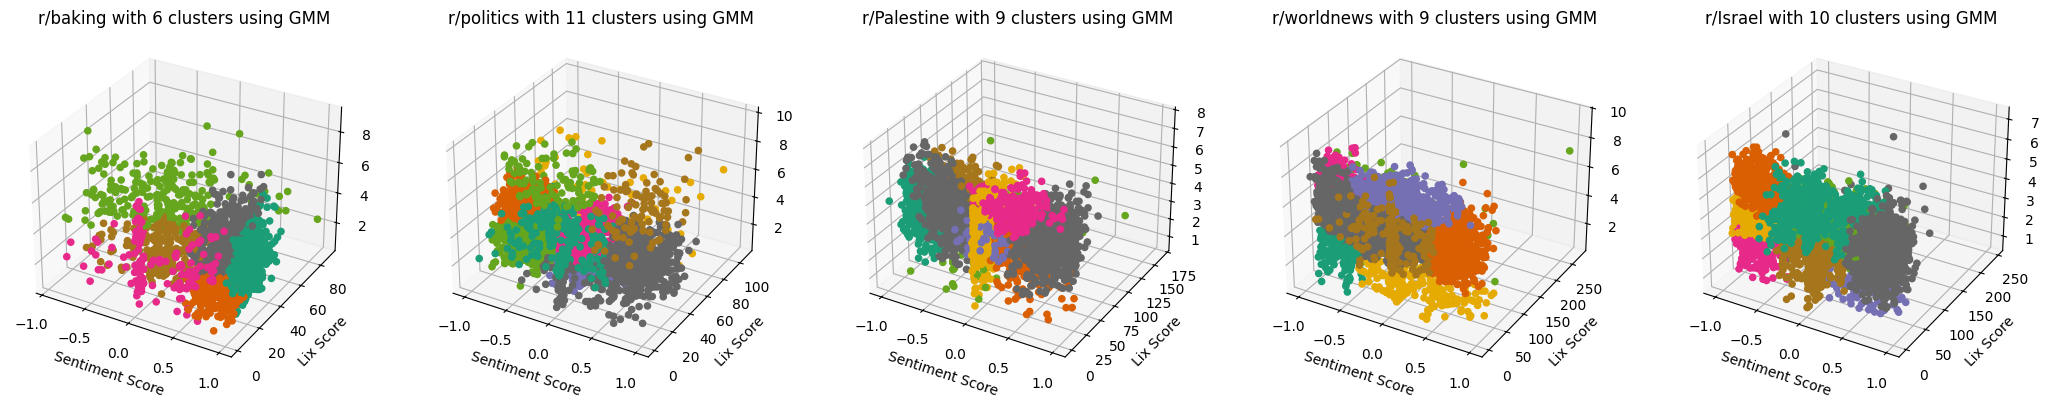

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=n_subs, figsize=(26, 5), subplot_kw={'projection': '3d'})

method = 'GMM'
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    
    # Assign transparency: 50% for cluster -1, 100% (1.0) for others
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)

    # Handle valid colors for other clusters
    # Replace 'None' with colormap values for non -1 clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df['sentiment_score'], df['lix_score'], df['log_upvotes'],
        facecolors=cluster_colors, alpha=alphas
    )
    axes[i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')

plt.show()


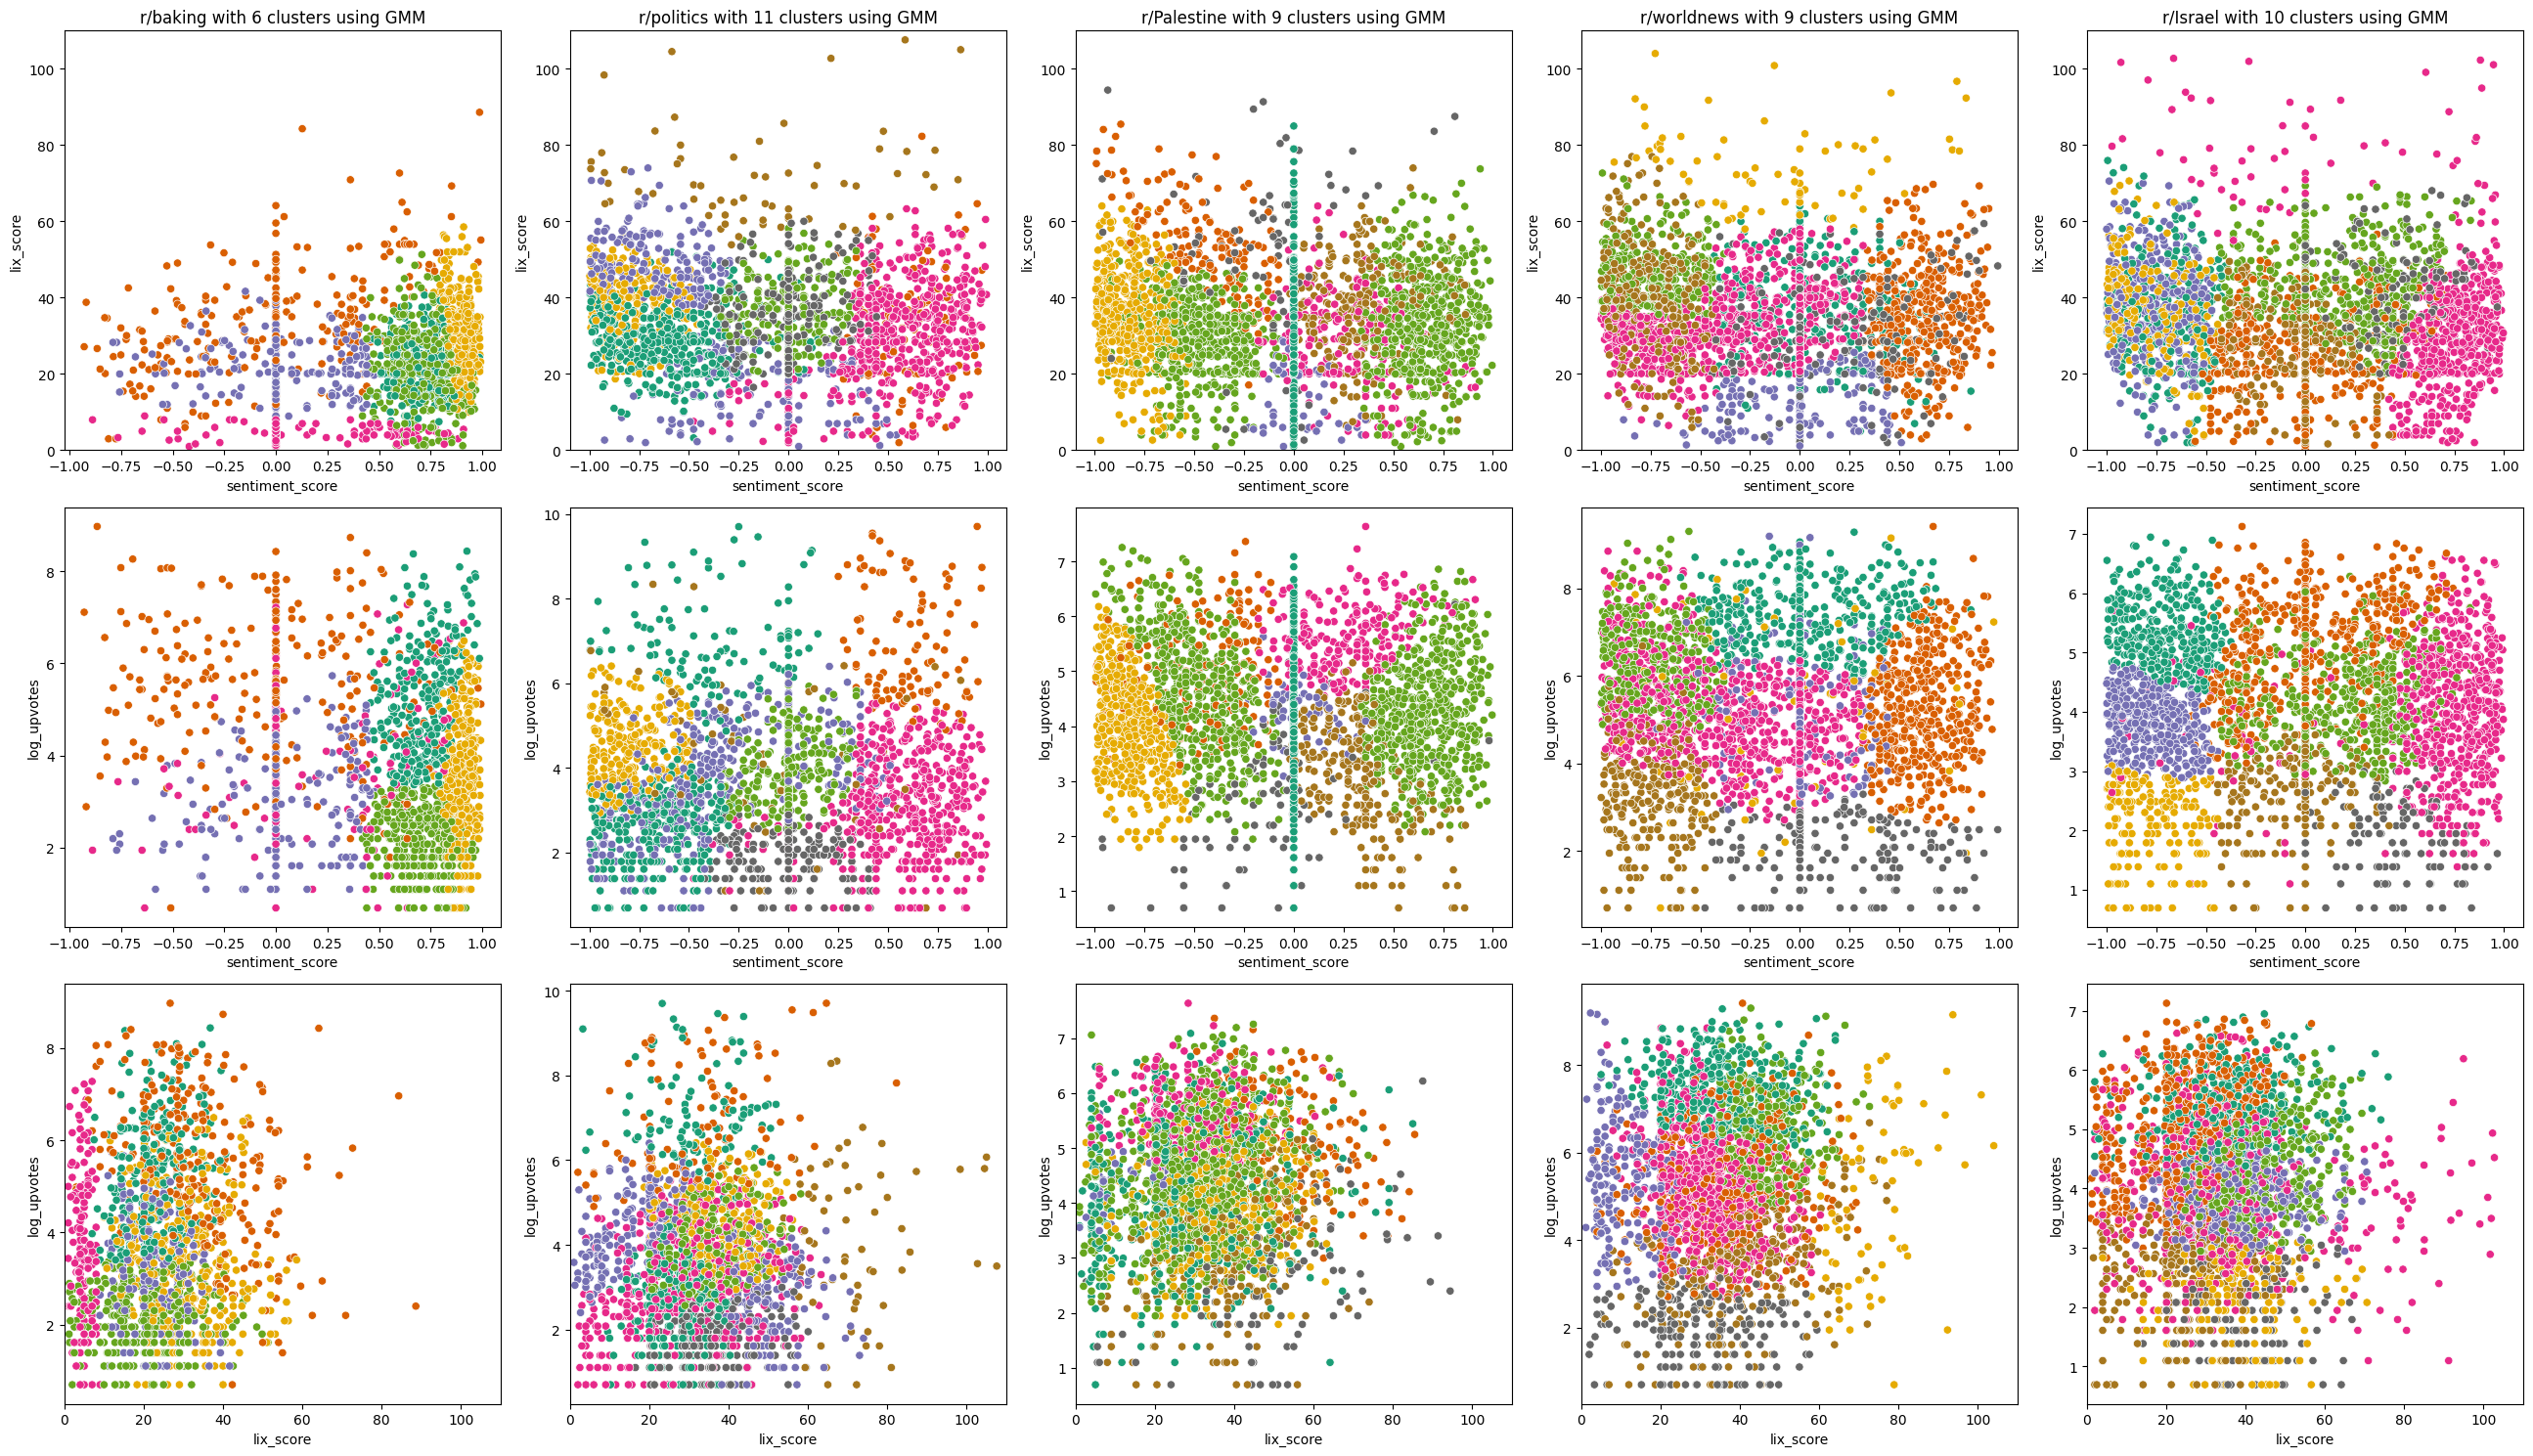

In [135]:
fig, axes = plt.subplots(nrows=3, ncols=n_subs, figsize=(26, 15))

lix_lim = [0, 110]

method = 'GMM'
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)
    
    # Handle valid colors for other clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 2D scatterplots
    sns.scatterplot(ax=axes[0, i], data=df, x="sentiment_score", y="lix_score", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[1, i], data=df, x="sentiment_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[2, i], data=df, x="lix_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)

    axes[0, i].set_ylim(lix_lim)
    axes[2, i].set_xlim(lix_lim)

    axes[0, i].set_title(f'r/{sub} with {n_clusters} clusters using GMM')

plt.tight_layout()
plt.show()

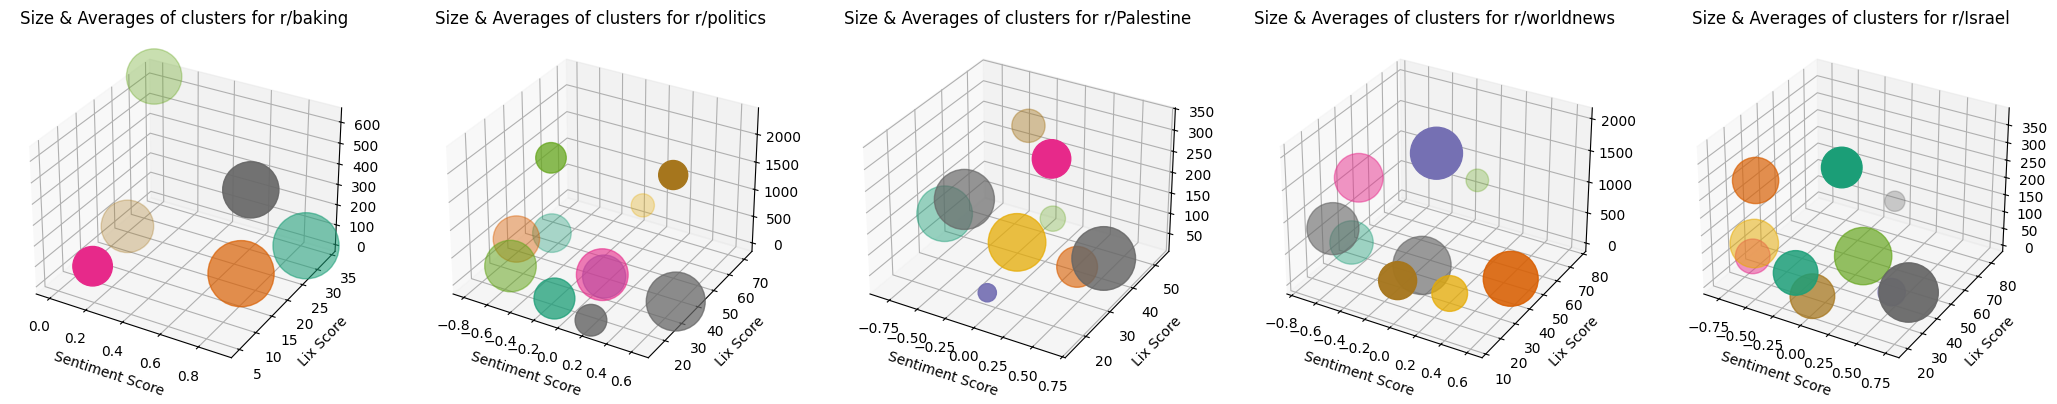

In [136]:
cluster_stats = {}

method = 'GMM' #Can also be "DBSCAN"
cluster_type = f'{method}_cluster'

for sub, df in dfs_clustered.items():
    cluster_stats[sub] = pd.DataFrame(columns=['cluster', 'percentage', 'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score'])
    total_observations = len(df)
    for cluster in df[cluster_type].unique():
        cluster_df = df[df[cluster_type] == cluster]
        percentage = len(cluster_df) / total_observations * 100
        avg_upvotes = cluster_df['upvotes'].mean()
        avg_lix_score = cluster_df['lix_score'].mean()
        avg_sentiment_score = cluster_df['sentiment_score'].mean()
        
        cluster_stats[sub].loc[cluster] = {
            'cluster': cluster,
            'percentage': percentage,
            'avg_upvotes': avg_upvotes,
            'avg_lix_score': avg_lix_score,
            'avg_sentiment_score': avg_sentiment_score
        }

fig, axes = plt.subplots(nrows = 1, ncols = n_subs, figsize=(26, 5), subplot_kw={'projection':'3d'})

for i, (sub, df) in enumerate(cluster_stats.items()):
    n_clusters = df.shape[0]
    # #Plot the 3d scatterplot
    axes[i].scatter(df['avg_sentiment_score'], df['avg_lix_score'], df['avg_upvotes'], facecolors='none', c = df['cluster'], cmap = 'Dark2', s = df['percentage']*100)
    axes[i].set_title(f'Size & Averages of clusters for r/{sub}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')